# Probabilistic

Here we're going to train the generator, that outputs the probability distribution
of the $x_{enemy}$. To do that we will use the **REINFORCE** algorithm.

In [34]:
from typing import Union, Literal

import numpy as np
import torch
from IPython.core.display import display
from numba import njit, prange
from torch import nn
from torch.distributions import Normal
from torch.optim import Adam

from environments import PendulumEnvJIT
from environments.pendulum import State
from environments.pendulum.state import size as state_size
from evaluators import DirectEvaluator, TrajectoryRewardsEvaluator
from evaluators.direct_actor import Actor
from evaluators.utils import weight_skills
from renderer import render_single_enemy
from shared_parameters import enemy_x_min, enemy_x_max, connector_length, max_angle, enemy_radius, bob_radius, \
    skill_weighting, max_trajectory_length, vertical_speed, enemy_y, current_angle, \
    position, angular_speed
from utils import MLP, TrainUntil

Our generator will output the mean and std of the normal distribution for the $x_{enemy}$

In [35]:
class Generator(nn.Module):
    def __init__(self, state_size, hidden=None, activation:Union[Literal["relu"], Literal["lrelu"]]="relu", min_std=0.01):
        super().__init__()

        if not hidden:
            self.base = nn.Identity()
            self.mean = nn.Linear(1, state_size)
            self.std = nn.Linear(1, state_size)

        else:
            self.base = MLP(1, hidden[-1], hidden)
            self.mean = nn.Linear(hidden[-1], state_size)
            self.std = nn.Linear(hidden[-1], state_size)

        self.activation = nn.ReLU() if activation == "relu" else nn.LeakyReLU()

        assert min_std > 0
        self.min_std = min_std
        self.softplus = nn.Softplus()


    def forward(self, x):
        x = self.base(x)
        x = self.activation(x)

        mean = self.mean(x)

        std = self.std(x)
        std = self.softplus(std)

        return mean, std

Generator(1, [4], activation="lrelu")

Generator(
  (base): MLP(
    (activation): ReLU()
    (layers): ModuleList(
      (0): Linear(in_features=1, out_features=4, bias=True)
      (1): Linear(in_features=4, out_features=4, bias=True)
    )
  )
  (mean): Linear(in_features=4, out_features=1, bias=True)
  (std): Linear(in_features=4, out_features=1, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (softplus): Softplus(beta=1, threshold=20)
)

Now we can use any method of difficulty estimation to estimate the difficulty of the given levels.

In [36]:
sample_size = 50
constrain_weight = 1

First, let's try it out with the `DirectEvaluator`

In [37]:
evaluator = DirectEvaluator(connector_length, max_angle, enemy_radius, bob_radius)

generator = Generator(state_size=1, hidden=[4], activation="lrelu", min_std=0.1)
optim = Adam(generator.parameters(), lr=0.001)

d_in = torch.linspace(0, 1, 100).unsqueeze(1)

with TrainUntil(1e-4, 100, 10000, print_frequency=100, clear=True) as trainer:
    while not trainer.done:

        # Generate mean and std, create a distribution
        mean, std = generator(d_in)
        distribution = Normal(mean, std)

        # Sample from the distribution and the log probabilities
        x = distribution.sample([sample_size])
        log_prob = distribution.log_prob(x)

        # Transpose to [batch_size, sample_size, 1]
        x = x.transpose(0, 1)
        log_prob = log_prob.transpose(0, 1)

        # Constrain the samples to a valid range
        x_constrained = x.clamp(enemy_x_min, enemy_x_max)

        # Compute basic loss of the clamped samples
        # d_out will just be the distance from the target
        # this is simply how we chose it to be for this case
        d_out = evaluator.evaluate(x_constrained)

        # Difference in the difficulties we will minimize
        # d_in shape [batch_size, 1] -> [batch_size, 1, 1] -> [batch_size, sample_size, 1]
        difference = (d_out - d_in.unsqueeze(1)).abs()

        # Compute the clamp penalty
        clamp_penalty = (x_constrained - x).abs()

        # Weight everything together
        # - minimize the difference in d_in and d_out
        # - minimize the difference between x and x_constrained
        loss = ((difference + constrain_weight * clamp_penalty) * log_prob).mean()

        # Total weighted loss
        optim.zero_grad()
        loss.backward()
        optim.step()

        trainer.loss = (evaluator.evaluate(mean) - d_in).abs().mean()

Done after 10001 iteration(s). Loss: 0.500000


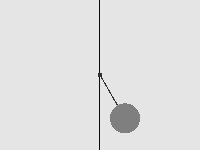

0.0

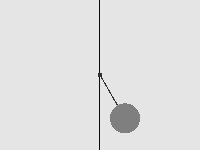

0.1111111119389534

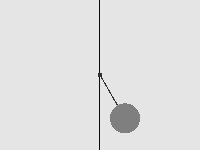

0.2222222238779068

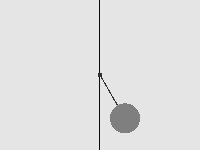

0.3333333432674408

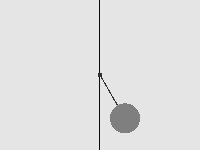

0.4444444477558136

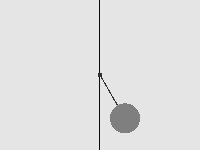

0.5555555820465088

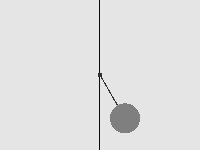

0.6666666269302368

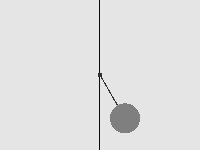

0.7777777910232544

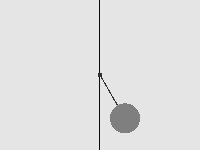

0.8888888955116272

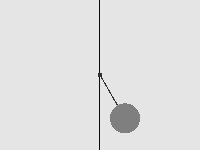

1.0

In [38]:
d_in = torch.linspace(0, 1, 10).unsqueeze(1)

with torch.no_grad():
    means, stds = generator(d_in)

enemy_xs = Normal(means, stds).sample([1]).transpose(0, 1)

for enemy_x, d in zip(enemy_xs, d_in):
    display(render_single_enemy(enemy_x.item(), 0.25))
    display(d.item())

Now let's use `TrajectoryRewardsEvaluator`

In [ ]:
env = PendulumEnvJIT()
skills = torch.linspace(0, 1, 10)
actors = [Actor(skill) for skill in skills.numpy()]
actors_weights = weight_skills(skills, skill_weighting.mean, skill_weighting.std, skill_weighting.skew)

generator = Generator(state_size=1, hidden=[4], activation="lrelu", min_std=0.1)
evaluator = TrajectoryRewardsEvaluator(env, actors, actors_weights, 10, max_trajectory_length)

d_in = torch.linspace(0, 1, 100).unsqueeze(1)

@njit(parallel=True)
def transform(x):
    states = np.zeros((x.shape[0], x.shape[1], state_size), dtype=np.float32)
    for i in prange(x.shape[0]):
        for j in prange(x.shape[1]):
            states[i][j] = State(bob_radius, max_angle, connector_length, vertical_speed, x[i][j][0], enemy_y,
                                 enemy_radius, current_angle, position, angular_speed)
    return states

with TrainUntil(1e-4, 100, 10000, print_frequency=1, clear=True) as trainer:
    while not trainer.done:

        # Generate mean and std, create a distribution
        mean, std = generator(d_in)
        distribution = Normal(mean, std)

        # Sample from the distribution and the log probabilities
        x = distribution.sample([sample_size])
        log_prob = distribution.log_prob(x)

        # Transpose to [batch_size, sample_size, 1]
        x = x.transpose(0, 1)
        log_prob = log_prob.transpose(0, 1)

        # Constrain the samples to a valid range
        x_constrained = x.clamp(enemy_x_min, enemy_x_max)

        # Compute basic loss of the clamped samples
        # d_out will just be the distance from the target
        # this is simply how we chose it to be for this case
        states = transform(x.numpy().astype(np.float32))
        d_out = torch.from_numpy(evaluator.evaluate(states)).type(torch.float32)

        # Difference in the difficulties we will minimize
        # d_in shape [batch_size, 1] -> [batch_size, 1, 1] -> [batch_size, sample_size, 1]
        difference = (d_out - d_in.unsqueeze(1)).abs()

        # Compute the clamp penalty
        clamp_penalty = (x_constrained - x).abs()

        # Weight everything together
        # - minimize the difference in d_in and d_out
        # - minimize the difference between x and x_constrained
        loss = ((difference + constrain_weight * clamp_penalty) * log_prob).mean()

        # Total weighted loss
        optim.zero_grad()
        loss.backward()
        optim.step()

        trainer.loss = difference.mean()


Iteration: 2243, loss: 0.4177600


In [ ]:
d_in = torch.linspace(0, 1, 10).unsqueeze(1)

with torch.no_grad():
    means, stds = generator(d_in)

enemy_xs = Normal(means, stds).sample([1]).transpose(0, 1)

for enemy_x, d in zip(enemy_xs, d_in):
    display(render_single_enemy(enemy_x.item(), 0.25))
    display(d.item())